# QUESTION - 1


In [27]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch.nn as nn
import torch.optim as optim


In [28]:
DATASET_PATH = "D:/local/IISC-1st SEM/DIP/DIP-Assignment-5/Images"

In [29]:
# Initialize ResNet
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove classification head

In [30]:
# Preprocessing Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
# Helper function to load images and labels
def load_images_and_labels(folder_path, classes):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)
        for file_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file_name)
            image = Image.open(img_path).convert("RGB")
            images.append(image)
            labels.append(label)
    return images, labels

In [32]:
# Define train/test class folders
classes = ["airplanes_train", "bikes_train", "cars_train", "faces_train"]
test_classes = [c.replace("train", "test") for c in classes]

In [33]:
# Load train and test data
train_images, train_labels = load_images_and_labels(DATASET_PATH, classes)
test_images, test_labels = load_images_and_labels(DATASET_PATH, test_classes)

In [34]:
# Feature Extraction
def extract_features(images, model):
    model.eval()
    features = []
    with torch.no_grad():
        for img in images:
            img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
            feature_vector = model(img_tensor)
            features.append(feature_vector.numpy().flatten())  # Flatten to 1D
    return features

In [35]:
train_features = extract_features(train_images, model)
test_features = extract_features(test_images, model)

In [36]:
# Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [37]:
# Evaluate on Test Data
test_predictions = knn.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 100.00%


In [38]:
import numpy as np

# Perform t-SNE on train and test features
tsne = TSNE(n_components=2, random_state=42)
features_combined = np.concatenate((train_features, test_features), axis=0)
features_2d = tsne.fit_transform(features_combined)
labels_combined = train_labels + test_labels

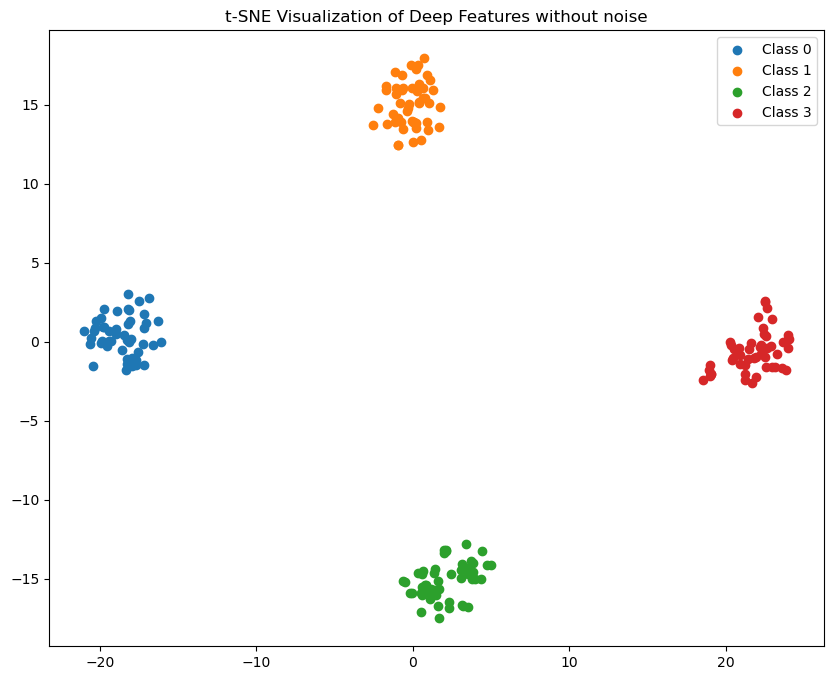

In [39]:
# Plot the 2D features
plt.figure(figsize=(10, 8))
for label in set(labels_combined):
    indices = [i for i, lbl in enumerate(labels_combined) if lbl == label]
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=f"Class {label}")
plt.legend()
plt.title("t-SNE Visualization of Deep Features without noise")
plt.show()

# QUESTION -2

In [40]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, train_features, train_labels, cv=5)  # 5-fold CV
print(f"Cross-Validation Accuracy: {scores.mean() * 100:.2f}% ± {scores.std() * 100:.2f}%")

Cross-Validation Accuracy: 100.00% ± 0.00%


In [41]:
def add_gaussian_noise_vectorized(images, std):
    noisy_images = []
    for img in images:
        img_array = np.array(img) / 255.0  # Normalize
        noise = np.random.normal(0, std / 255.0, img_array.shape)  # Scaled noise
        noisy_img = np.clip(img_array + noise, 0, 1)  # Add noise
        noisy_images.append(Image.fromarray((noisy_img * 255).astype(np.uint8)))
    return noisy_images

In [42]:
noise_levels = [1, 10, 25, 50, 100]

In [43]:
results = {
    "Noise Level": [],
    "Test Accuracy": [],
    "Cross-Validation Accuracy": [],
    "CV Std Dev": []
}

Processing noise level: 1
Test Accuracy with Noise Std 1: 100.00%
Cross-Validation Accuracy: 100.00% ± 0.00%


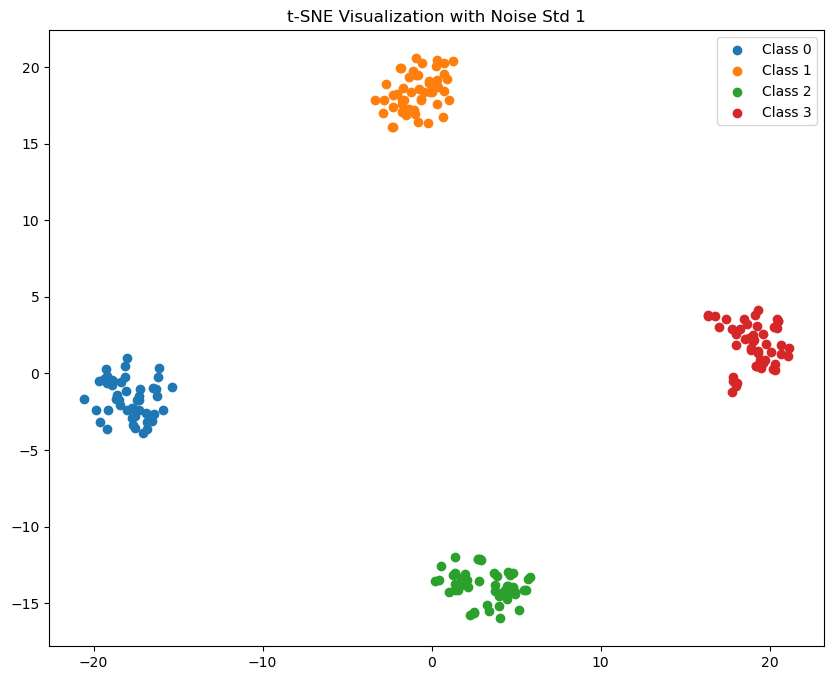

Processing noise level: 10
Test Accuracy with Noise Std 10: 100.00%
Cross-Validation Accuracy: 100.00% ± 0.00%


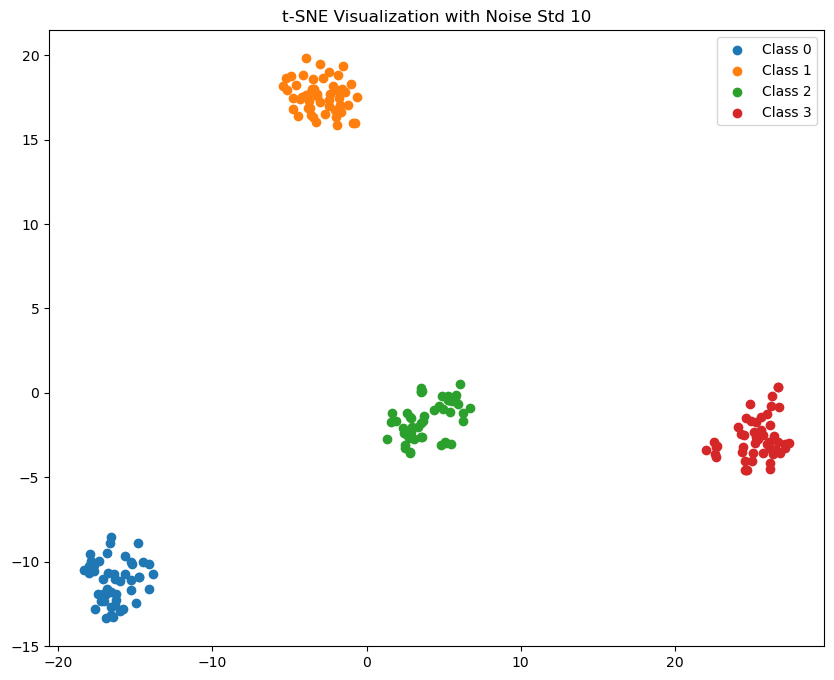

Processing noise level: 25
Test Accuracy with Noise Std 25: 100.00%
Cross-Validation Accuracy: 100.00% ± 0.00%


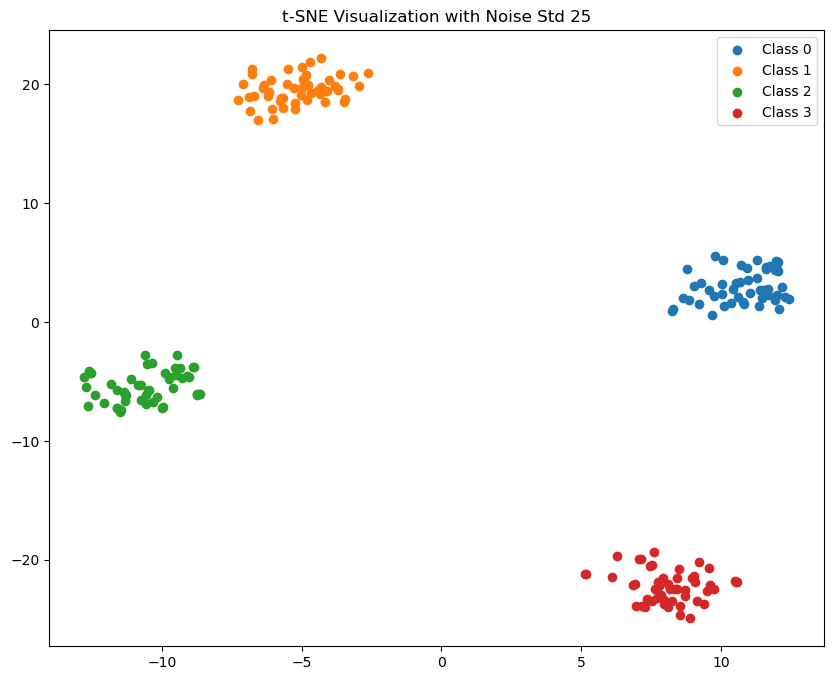

Processing noise level: 50
Test Accuracy with Noise Std 50: 100.00%
Cross-Validation Accuracy: 100.00% ± 0.00%


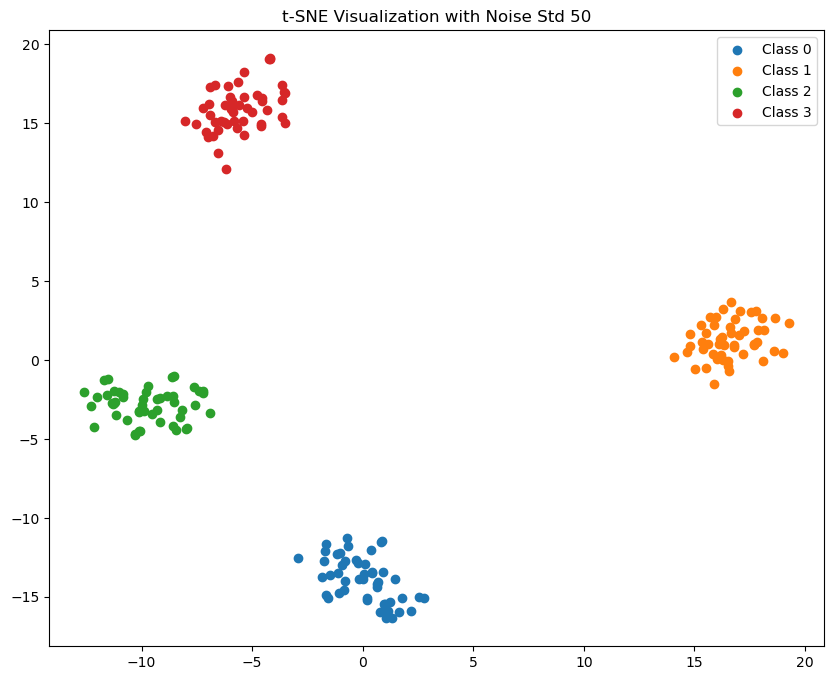

Processing noise level: 100
Test Accuracy with Noise Std 100: 100.00%
Cross-Validation Accuracy: 98.33% ± 2.04%


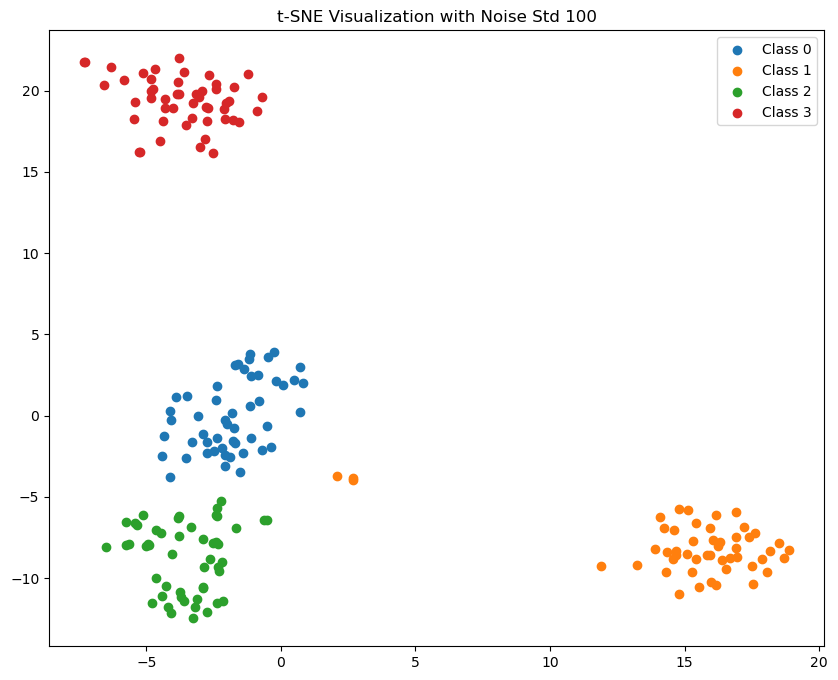

In [44]:
for std in noise_levels:
    print(f"Processing noise level: {std}")

    # Add noise to train and test images
    noisy_train_images = add_gaussian_noise_vectorized(train_images, std=std)
    noisy_test_images = add_gaussian_noise_vectorized(test_images, std=std)

    # Extract features
    train_features = extract_features(noisy_train_images, model)
    test_features = extract_features(noisy_test_images, model)

    # Train and Evaluate KNN
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_features, train_labels)
    predictions = knn.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Test Accuracy with Noise Std {std}: {accuracy * 100:.2f}%")

    # Cross-validation
    scores = cross_val_score(knn, train_features, train_labels, cv=5)
    cv_mean = scores.mean() * 100
    cv_std = scores.std() * 100
    print(f"Cross-Validation Accuracy: {cv_mean:.2f}% ± {cv_std:.2f}%")

    # Store results
    results["Noise Level"].append(std)
    results["Test Accuracy"].append(accuracy * 100)
    results["Cross-Validation Accuracy"].append(cv_mean)
    results["CV Std Dev"].append(cv_std)

    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42)
    features_combined = np.concatenate((train_features, test_features), axis=0)
    features_2d = tsne.fit_transform(features_combined)
    labels_combined = train_labels + test_labels

    # Plot t-SNE
    plt.figure(figsize=(10, 8))
    for label in set(labels_combined):
        indices = [i for i, lbl in enumerate(labels_combined) if lbl == label]
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=f"Class {label}")
    plt.legend()
    plt.title(f"t-SNE Visualization with Noise Std {std}")
    plt.show()

In [45]:
print("\nFinal Results:")
for i in range(len(noise_levels)):
    print(f"Noise Std {results['Noise Level'][i]}: "
          f"Test Accuracy = {results['Test Accuracy'][i]:.2f}%, "
          f"CV Accuracy = {results['Cross-Validation Accuracy'][i]:.2f}% ± {results['CV Std Dev'][i]:.2f}%")


Final Results:
Noise Std 1: Test Accuracy = 100.00%, CV Accuracy = 100.00% ± 0.00%
Noise Std 10: Test Accuracy = 100.00%, CV Accuracy = 100.00% ± 0.00%
Noise Std 25: Test Accuracy = 100.00%, CV Accuracy = 100.00% ± 0.00%
Noise Std 50: Test Accuracy = 100.00%, CV Accuracy = 100.00% ± 0.00%
Noise Std 100: Test Accuracy = 100.00%, CV Accuracy = 98.33% ± 2.04%


# QUESTION - 3

In [46]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = self.transform(img)  # Apply preprocessing
        return img, label

In [47]:
train_dataset = CustomDataset(noisy_train_images, train_labels, transform)
test_dataset = CustomDataset(noisy_test_images, test_labels, transform)

In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [49]:
# Fine-Tune the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace classification head
model = model.to(device)

c:\Users\New Fly High\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\New Fly High\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [51]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [52]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50], Loss: 1.1518
Epoch [2/50], Loss: 0.6064
Epoch [3/50], Loss: 0.4356
Epoch [4/50], Loss: 0.2854
Epoch [5/50], Loss: 0.1661
Epoch [6/50], Loss: 0.2096
Epoch [7/50], Loss: 0.2316
Epoch [8/50], Loss: 0.1631
Epoch [9/50], Loss: 0.1288
Epoch [10/50], Loss: 0.1221
Epoch [11/50], Loss: 0.1459
Epoch [12/50], Loss: 0.0941
Epoch [13/50], Loss: 0.0981
Epoch [14/50], Loss: 0.0467
Epoch [15/50], Loss: 0.1505
Epoch [16/50], Loss: 0.0902
Epoch [17/50], Loss: 0.0544
Epoch [18/50], Loss: 0.0682
Epoch [19/50], Loss: 0.1442
Epoch [20/50], Loss: 0.1025
Epoch [21/50], Loss: 0.1146
Epoch [22/50], Loss: 0.2977
Epoch [23/50], Loss: 0.1841
Epoch [24/50], Loss: 0.0542
Epoch [25/50], Loss: 0.0589
Epoch [26/50], Loss: 0.0927
Epoch [27/50], Loss: 0.0565
Epoch [28/50], Loss: 0.0946
Epoch [29/50], Loss: 0.0382
Epoch [30/50], Loss: 0.0528
Epoch [31/50], Loss: 0.0329
Epoch [32/50], Loss: 0.0284
Epoch [33/50], Loss: 0.0269
Epoch [34/50], Loss: 0.1519
Epoch [35/50], Loss: 0.1073
Epoch [36/50], Loss: 0.0365
E

In [53]:
# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

In [54]:
accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy after Fine-Tuning: {accuracy * 100:.2f}%")

Test Accuracy after Fine-Tuning: 98.75%
